<a href="https://colab.research.google.com/github/lee-messi/machine-learning/blob/main/amazon-reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install tensorflow_hub
!pip install tensorflow_text
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 4.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 1.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.0 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 8.5 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 kB 3.7 MB/s eta 0:00:00


## Import all packages

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt

## Preprocess Amazon Review Data

In [6]:
# Depends on the repository to which 'Prime_Pantry_5.json' is saved.
df = pd.read_json('~/Downloads/Prime_Pantry_5.json', lines = True)

In [7]:
df = df[['reviewText', 'overall']]
df = df.dropna()
df.overall = df.overall - 1
df.overall = df.overall.astype('category')

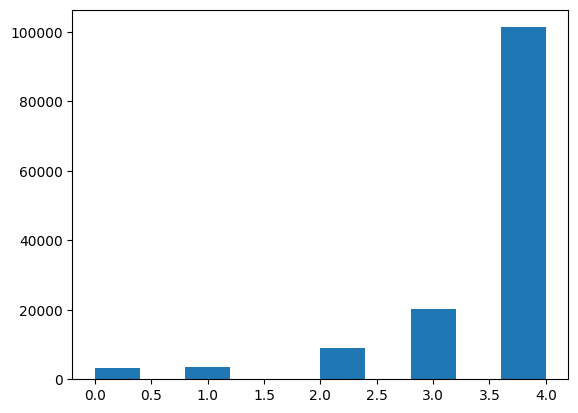

In [8]:
plt.hist(df.overall)
plt.show()

In [9]:
df_balanced = df.groupby(df.overall).sample(1000)

In [10]:
train, val, test = np.split(df_balanced.sample(frac = 1), [int(0.8 * len(df_balanced)), int(0.9 * len(df_balanced))])

In [11]:
'{}{}{}'.format(train.shape, val.shape, test.shape)

'(4000, 2)(500, 2)(500, 2)'

## Create a tf.data Dataset from a Pandas Dataframe

In [12]:
def df_to_dataset(dataframe, shuffle = True, batch_size = 128):
  df = dataframe.copy()
  label = df.overall
  df = df.reviewText
  ds = tf.data.Dataset.from_tensor_slices((df, label))
  if shuffle == True:
    ds = ds.shuffle(buffer_size = len(df))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return(ds)

In [13]:
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val)
test_ds = df_to_dataset(test)

Define, Compile, and Fit Model

In [14]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype = tf.string, trainable = True)

In [15]:
model = tf.keras.models.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5, activation = 'softmax'))

In [16]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics = ['accuracy'])

In [17]:
model.evaluate(train_ds)

2023-06-23 00:30:44.757312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [4000]
	 [[{{node Placeholder/_1}}]]
2023-06-23 00:30:44.758869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [4000]
	 [[{{node Placeholder/_1}}]]
2023-06-23 00:30:45.535477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sentences' with dtype string and shape [?]
	 [[{{no

32/32 [==============================] - 2s 5ms/step - loss: 1.6319 - accuracy: 0.2218


[1.6319427490234375, 0.22175000607967377]

In [18]:
history = model.fit(train_ds,
                    epochs = 7,
                    validation_data = val_ds)

Epoch 1/7


2023-06-23 00:30:52.611001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,50]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-06-23 00:30:52.611195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3' with dtype int64 and shape [?]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3}}]]


32/32 [==============================] - ETA: 0s - loss: 1.5558 - accuracy: 0.2885

2023-06-23 00:31:26.951446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [500]
	 [[{{node Placeholder/_1}}]]
2023-06-23 00:31:26.952034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [500]
	 [[{{node Placeholder/_1}}]]


32/32 [==============================] - 36s 1s/step - loss: 1.5558 - accuracy: 0.2885 - val_loss: 1.4657 - val_accuracy: 0.3560
Epoch 2/7
32/32 [==============================] - 38s 1s/step - loss: 1.2171 - accuracy: 0.5035 - val_loss: 1.3741 - val_accuracy: 0.4240
Epoch 3/7
32/32 [==============================] - 39s 1s/step - loss: 0.8744 - accuracy: 0.6668 - val_loss: 1.4404 - val_accuracy: 0.4320
Epoch 4/7
32/32 [==============================] - 39s 1s/step - loss: 0.5889 - accuracy: 0.7970 - val_loss: 1.6010 - val_accuracy: 0.4340
Epoch 5/7
32/32 [==============================] - 40s 1s/step - loss: 0.4215 - accuracy: 0.8572 - val_loss: 1.8180 - val_accuracy: 0.4260
Epoch 6/7
32/32 [==============================] - 39s 1s/step - loss: 0.3110 - accuracy: 0.8938 - val_loss: 2.0444 - val_accuracy: 0.4160
Epoch 7/7
32/32 [==============================] - 39s 1s/step - loss: 0.2508 - accuracy: 0.9175 - val_loss: 2.2776 - val_accuracy: 0.4160


In [19]:
model.evaluate(test_ds)

2023-06-23 00:38:29.184207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [500]
	 [[{{node Placeholder/_0}}]]
2023-06-23 00:38:29.185374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [500]
	 [[{{node Placeholder/_1}}]]


4/4 [==============================] - 1s 269ms/step - loss: 2.2144 - accuracy: 0.4020


[2.214444398880005, 0.4020000100135803]

Validation accuracy stops increasing at epoch 4, and test accuracy is not very high. 

## Plot Train and Validation Accuracy of the Model

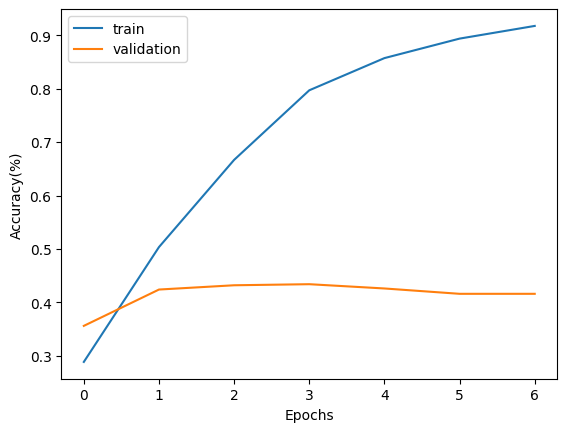

In [20]:
 plt.plot(history.history['accuracy'])
 plt.plot(history.history['val_accuracy'])
 plt.xlabel('Epochs')
 plt.ylabel('Accuracy(%)')
 plt.legend(['train', 'validation'])
 plt.show()

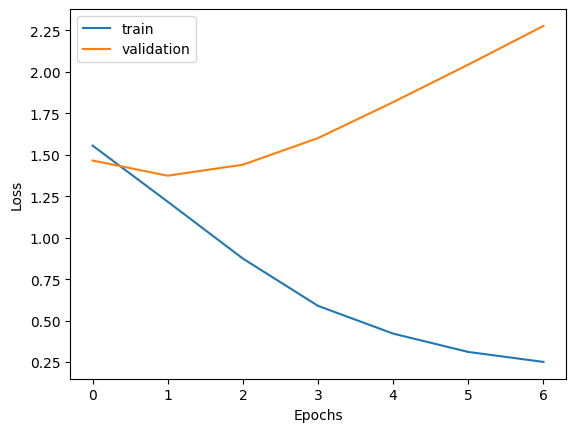

In [21]:
 plt.plot(history.history['loss'])
 plt.plot(history.history['val_loss'])
 plt.xlabel('Epochs')
 plt.ylabel('Loss')
 plt.legend(['train', 'validation'])
 plt.show()

Validation loss decreases at epoch 1 but then continues to increase in subsequent epochs whereas training loss continues to decrease. This is sign of early overfitting. 

In [29]:
model = tf.keras.models.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(5, activation = 'softmax'))

In [30]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics = ['accuracy'])

In [31]:
model.evaluate(train_ds)

2023-06-23 01:16:03.195956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


32/32 [==============================] - 8s 225ms/step - loss: 1.6456 - accuracy: 0.2340


[1.6455684900283813, 0.23399999737739563]

In [32]:
simple = model.fit(train_ds,
                   epochs = 7,
                   validation_data = val_ds)

Epoch 1/7
32/32 [==============================] - 43s 1s/step - loss: 1.3071 - accuracy: 0.5745 - val_loss: 1.3777 - val_accuracy: 0.4240
Epoch 2/7
32/32 [==============================] - 40s 1s/step - loss: 0.7284 - accuracy: 0.8767 - val_loss: 1.3675 - val_accuracy: 0.4520
Epoch 3/7
32/32 [==============================] - 38s 1s/step - loss: 0.4536 - accuracy: 0.9057 - val_loss: 1.4659 - val_accuracy: 0.4460
Epoch 4/7
32/32 [==============================] - 37s 1s/step - loss: 0.3196 - accuracy: 0.9243 - val_loss: 1.5846 - val_accuracy: 0.4260
Epoch 5/7
32/32 [==============================] - 37s 1s/step - loss: 0.2485 - accuracy: 0.9350 - val_loss: 1.7043 - val_accuracy: 0.4220
Epoch 6/7
32/32 [==============================] - 38s 1s/step - loss: 0.2031 - accuracy: 0.9430 - val_loss: 1.8243 - val_accuracy: 0.4040
Epoch 7/7
32/32 [==============================] - 36s 1s/step - loss: 0.1744 - accuracy: 0.9475 - val_loss: 1.9148 - val_accuracy: 0.4000


In [35]:
model.evaluate(test_ds)

4/4 [==============================] - 1s 181ms/step - loss: 1.8813 - accuracy: 0.3860


[1.8813085556030273, 0.38600000739097595]